# Assignment #3

##  Implementing the LoG scale blob detector (60 points):

Implement the Laplacian of Gaussian blob detector including scale space tracking. For this, first write a function LoG(sigma=1,size=19), in which the first argument is the parameter of the Gaussian kernel and the second argument is the overall image size of the filter (here by default 19x19 pixels). The function should return a numpy array with the filter values. At each pixel (x,y), the LoG has the value of (note, that the values have to be CENTERED in the window!!):

$$\textrm{LoG}(x,y)=-\frac{1}{\pi \sigma^4}(1-\frac{x^2+y^2}{2\sigma^2})e^{-\frac{x^2+y^2}{2\sigma^2}}$$

Insert code that shows LoG filters for sigmas from 1 to 10 in steps of 1 with a size of
19 pixels.

Insert another function called filterImg(img,fil), which performs a convolution of img with fil and returns the filtered image as its return value. MAKE SURE that the return image has the SAME size as the input image img!!!

Insert another function called trackScale(img,sigmas,size,threshold) that

1. Creates len(sigmas) LoG filters with the sigmas in the array for the specified size
2. Filters img with each LoG filter
3. For each pixel in the stack of filtered images, finds the maximum value and stores this in a return array called totScale
4. Plots the input picture img with overlays of the SCALED blobs that were found similar to the pictures in class on slides 79,84

Use the following picture (again, you may need to convert to PNG so you can read it in with matplotlib code)
 https://img1.southernliving.timeinc.net/sites/default/files/styles/4_3_horizontal_inbody_900x506/public/image/2018/07/main/the_sunflower_fields_at_neuse_river_greenway_trail.jpg?itok=ZOlvAuIg&1532035249

Insert code that uses good parameters for sigmas, size, and threshold so that you can find as many sunflower “blobs” as possible.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np # this is the only math-ish library,
import urllib
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
prof = 'https://img1.southernliving.timeinc.net/sites/default/files/styles/4_3_horizontal_inbody_900x506/public/image/2018/07/main/the_sunflower_fields_at_neuse_river_greenway_trail.jpg?itok=ZOlvAuIg&1532035249'
urllib.request.urlretrieve(prof,'sunflow.jpg')

jpg='sunflow'
img = Image.open(jpg+'.jpg')
img.save(jpg+".png",'png')

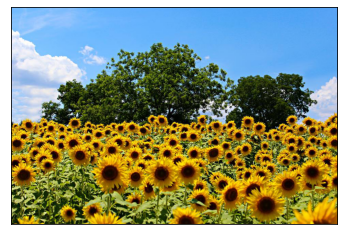

In [3]:
img = plt.imread('sunflow.png')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [5]:
mrimg = rgb2gray(img)
# mrimg = mrimg/255

In [16]:
sigmas = np.linspace(1,10,10)
size = 19

In [45]:
def LoG(sigma=1, size=19):
    fil = np.zeros((2*size+1, 2*size+1))
    for i in range(-size, size+1):
        for j in range(-size, size+1):
            tmp = (i*i+j*j)/(2*sigma*sigma)
            fil[i+size,j+size]=-1/(np.pi*np.power(sigma,4))*(1-tmp)*np.exp(-tmp)*(sigma*sigma)
    return fil

In [8]:
def convolution(img, weights):
    weights = weights.astype(float)
    filtered = np.zeros_like(img)
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]=np.sum(weights*img[j-width:j+width+1,i-height:i+height+1])
    return(filtered)

def filterImg(img,fil):
    image = convolution(img,fil) # convolving image
    return image

In [29]:
def trackScale(img,sigmas,size,threshold):
    log_images = []
    for i,sigma in enumerate(sigmas):
        log_images.append(filterImg(mrimg,LoG(sigma,size)))
    log_images = np.array([i for i in log_images])
    co_ordinates = []
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            pixel = log_images[:,i,j]
            pixel = np.reshape(pixel, (len(log_images),1,1))
            result = np.amax(pixel)
            if result >= threshold: #threshold
                z,x,y = np.unravel_index(pixel.argmax(),pixel.shape)
                co_ordinates.append((i+x-1,j+y-1,(z+1))) #finding co-rdinates
    co_ordinates = list(set(co_ordinates))
    print(len(co_ordinates))
    
    fig, ax = plt.subplots()
    nh,nw = mrimg.shape
    ax.imshow(mrimg, cmap='gray')
    for i, blob in enumerate(tqdm(co_ordinates)):
        y,x,r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False)
        ax.add_artist(c)
    ax.plot()  
    plt.show()
    
    return co_ordinates

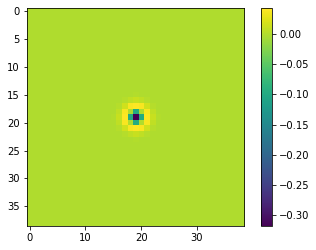

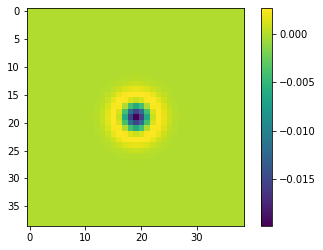

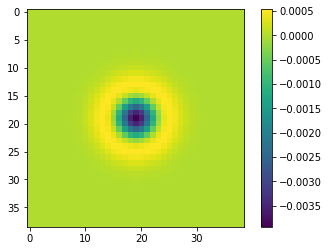

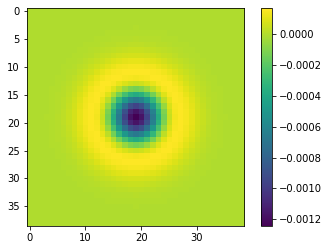

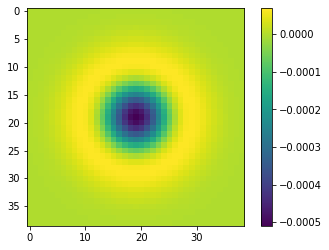

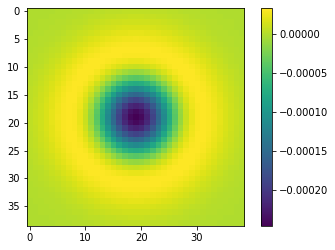

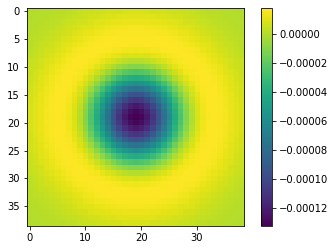

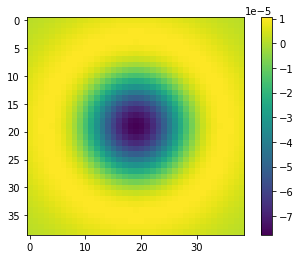

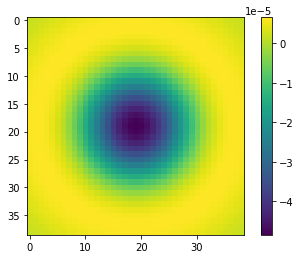

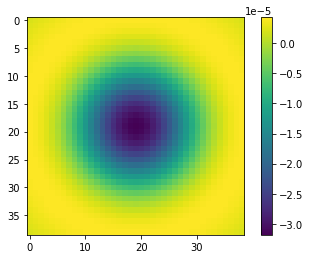

In [7]:
fil = []

for i,sigma in enumerate(np.linspace(1,10,10)):
    fil.append(LoG(sigma,19))
    plt.figure()
    plt.imshow(fil[i])
    plt.colorbar()

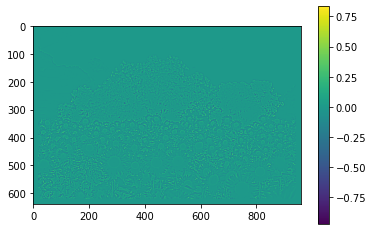

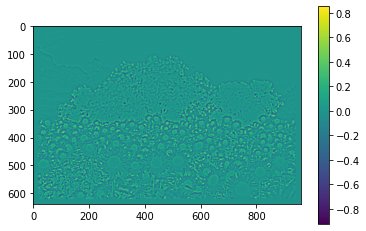

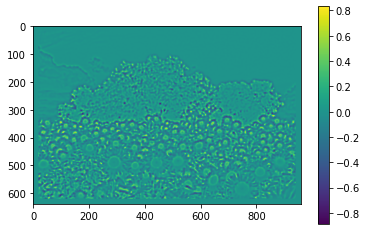

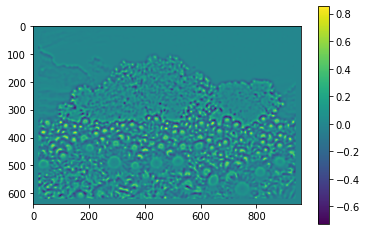

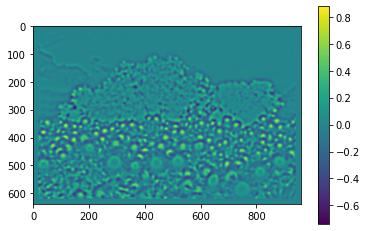

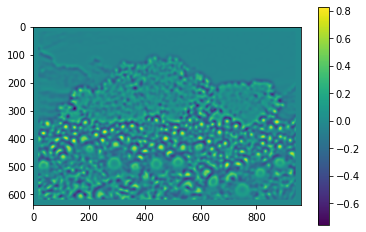

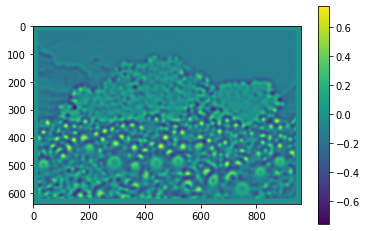

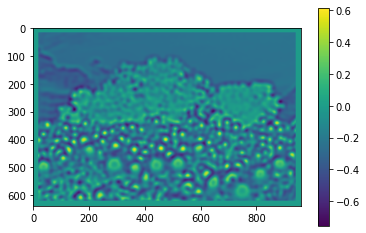

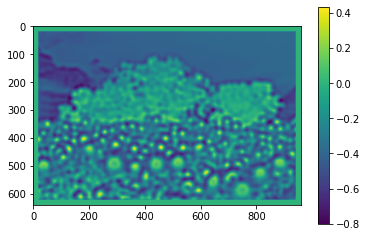

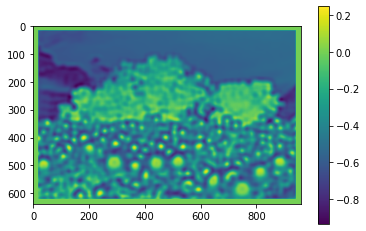

In [43]:
log_images = []

for i,sigma in enumerate(np.linspace(1,10,10)):
    log_images.append(filterImg(mrimg,LoG(sigma,19)))
    plt.figure()
    plt.imshow(log_images[i])
    plt.colorbar()

3557


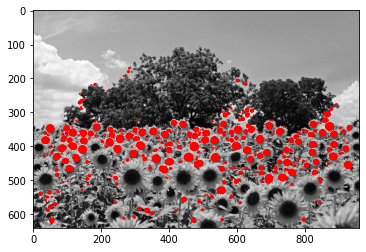

[(433, 461, 7),
 (442, 94, 5),
 (376, 302, 3),
 (375, 618, 3),
 (398, 120, 5),
 (529, 557, 6),
 (378, 91, 4),
 (404, 475, 6),
 (305, 866, 5),
 (399, 470, 6),
 (396, 115, 5),
 (448, 488, 6),
 (423, 293, 7),
 (453, 928, 6),
 (466, 381, 5),
 (543, 507, 1),
 (393, 884, 5),
 (347, 51, 6),
 (376, 92, 4),
 (384, 36, 5),
 (380, 39, 5),
 (396, 820, 5),
 (357, 116, 5),
 (344, 875, 6),
 (356, 318, 5),
 (410, 744, 5),
 (443, 402, 5),
 (408, 84, 5),
 (429, 458, 6),
 (352, 600, 6),
 (384, 781, 4),
 (443, 399, 5),
 (332, 560, 5),
 (400, 476, 6),
 (464, 672, 4),
 (416, 689, 5),
 (495, 694, 6),
 (431, 453, 6),
 (451, 493, 5),
 (389, 227, 6),
 (292, 629, 3),
 (410, 759, 1),
 (395, 823, 5),
 (409, 920, 5),
 (411, 662, 1),
 (435, 458, 7),
 (341, 868, 6),
 (463, 593, 2),
 (428, 68, 5),
 (559, 835, 1),
 (331, 412, 4),
 (361, 116, 6),
 (323, 859, 3),
 (404, 471, 6),
 (399, 115, 5),
 (376, 258, 6),
 (417, 823, 5),
 (410, 146, 6),
 (343, 739, 1),
 (347, 641, 4),
 (363, 510, 5),
 (383, 584, 3),
 (382, 107, 3),


In [46]:
trackScale(mrimg,sigmas,19,0.3)

## Bonus

BONUS PART Implement the solution to the heat equation for images (40
points):

Follow the slides and create an ipython notebook called heatImage.ipynb that implements the numerical solution to the 2D heat equation using an image as the starting “temperature” L(i,j,n), where i,j index pixels and n indexes the time step.

The easiest way is to simply use the final equation on the final slide and loop over all pixels to create the next estimate of L(i,j,n+1). You have to be a little careful with how you treat the pixels at the edge…

Use the sunflower image from above and run 100 time steps, plotting the result every 10 time steps.

---

In [37]:
def LoG_(sigma, size=19):
    #window size 
    n = np.ceil(sigma*6)
#     n=np.ceil(19*2)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

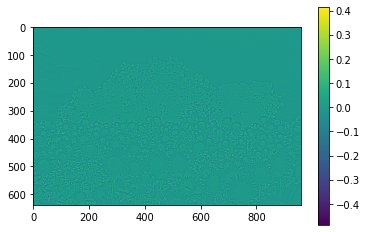

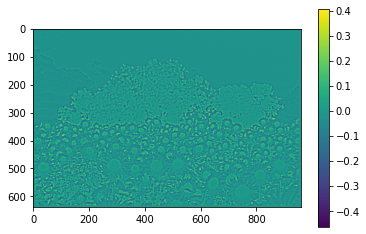

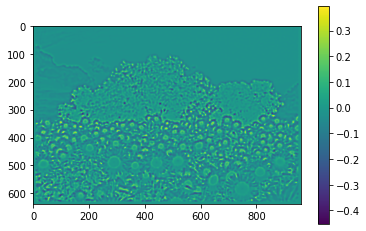

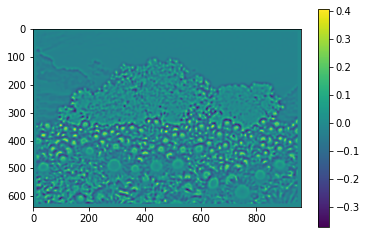

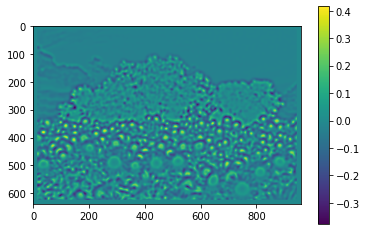

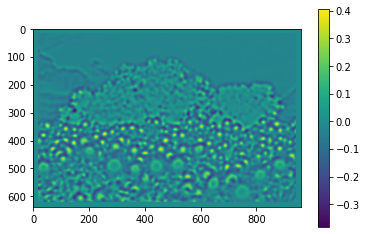

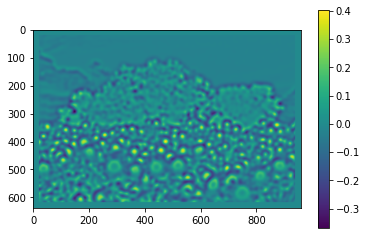

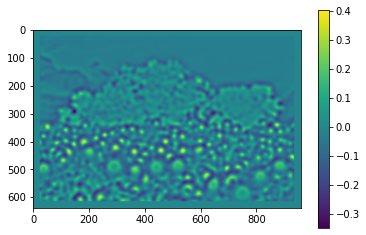

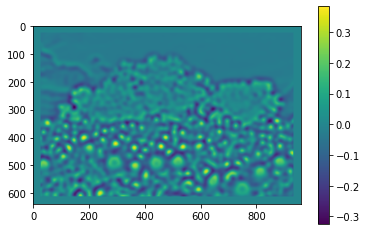

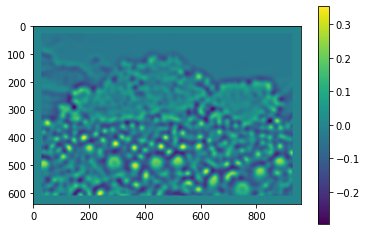

In [20]:
log_images = []

for i,sigma in enumerate(np.linspace(1,10,10)):
    log_images.append(filterImg(mrimg,LoG(sigma,19)))
    plt.figure()
    plt.imshow(log_images[i])
    plt.colorbar()

3277


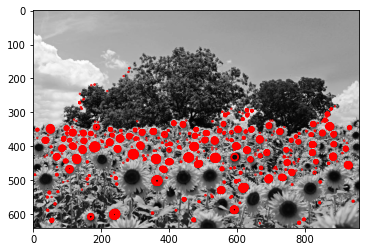

[(419, 298, 8),
 (436, 461, 8),
 (376, 302, 3),
 (398, 120, 5),
 (529, 557, 6),
 (378, 91, 4),
 (431, 458, 8),
 (305, 866, 5),
 (396, 115, 5),
 (448, 488, 6),
 (399, 114, 6),
 (466, 381, 5),
 (543, 507, 1),
 (393, 884, 5),
 (363, 886, 6),
 (531, 554, 7),
 (384, 36, 5),
 (401, 179, 9),
 (405, 248, 6),
 (380, 39, 5),
 (455, 931, 7),
 (410, 744, 5),
 (375, 252, 6),
 (400, 471, 7),
 (361, 852, 6),
 (332, 560, 5),
 (398, 116, 6),
 (432, 127, 7),
 (335, 442, 6),
 (416, 689, 5),
 (432, 68, 6),
 (495, 694, 6),
 (421, 295, 8),
 (389, 227, 6),
 (292, 629, 3),
 (385, 533, 7),
 (463, 593, 2),
 (494, 690, 7),
 (411, 662, 1),
 (453, 485, 7),
 (386, 226, 6),
 (341, 868, 6),
 (428, 68, 5),
 (331, 412, 4),
 (361, 116, 6),
 (431, 66, 6),
 (433, 533, 8),
 (323, 859, 3),
 (376, 258, 6),
 (417, 823, 5),
 (410, 146, 6),
 (343, 739, 1),
 (504, 362, 10),
 (483, 5, 2),
 (347, 48, 7),
 (382, 107, 3),
 (396, 315, 6),
 (363, 172, 3),
 (336, 825, 5),
 (430, 456, 8),
 (408, 247, 6),
 (357, 117, 6),
 (450, 488, 6),


In [25]:
trackScale(mrimg,sigmas,19,0.3)